## Imports

In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Nick\Documents\Year 2 Semester 1\ADS2001\Group Project\chipVariantCalling\chipVariantCalling_run1.tsv', sep = '\t')
df2 = pd.read_csv(r'C:\Users\Nick\Documents\Year 2 Semester 1\ADS2001\Group Project\chipVariantCalling\chipVariantCalling_run2.tsv', sep = '\t')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

C:\Users\Nick\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df.head()

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
0,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
1,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
2,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
3,4010289633,7281,26,0.0036,0.0033,MODERATE,GNB1,chr1:1747196_T/C,Baseline,Male,MS2083,2:2,3644:3596,12:14,34.0,1.182210,CHIP
4,4010289633,7282,29,0.0040,0.0036,MODERATE,GNB1,chr1:1747250_T/C,Baseline,Male,MS2083,2:2,3639:3606,15:14,32.7,1.061729,CHIP


## Cleaning

### Dropping Blanks & Duplicates

In [3]:
for i in df:
    df.dropna(subset=[i], how='any',inplace=True)
df = df[(df.chipOrControl != "Blank") & (df.chipOrControl != "Unknown")]
df.drop_duplicates(inplace=True)

### Converting Ratio to Integers

In [4]:
def ratio_to_int(string):
    a, b = string.split(":")
    if int(b) == 0:
        return 0
    else:
        return int(a) / int(b)

refbias = []
varbias = []

for ratio in df.REFBIAS.array:
    refbias.append(ratio_to_int(ratio)) 

for ratio in df.VARBIAS.array:
    varbias.append(ratio_to_int(ratio)) 
    
refbias = pd.Series(refbias)
varbias = pd.Series(varbias)

df['REFBIAS'] = refbias.values
df['VARBIAS'] = varbias.values

### Grouping Location into Chromosome Number

In [5]:
location = []
for loci in df.loci:
    location.append(loci.split(":")[0])

df['loci_shortened'] = pd.Series(location, index=df.index)
dict = {}
df_new = df
for ix, loci_shortened in zip(range(len(df_new['loci_shortened'].unique())), df_new['loci_shortened'].unique() ):
    dict[loci_shortened] = ix
    
df = df.replace({'loci_shortened': dict})
df["loci_shortened"] = df["loci_shortened"].astype(str).astype(float)

### Dropping Unnecessary Columns & Converting to Float

In [6]:
df = df.drop(['d.barcode','MSID','HIAF','loci','BIAS'], axis = 1)
shorted = ['IMPACT','sampleTimePt', 'gender', 'chipOrControl']
for i in shorted:
    df[f"{i}"] = df[f"{i}"].astype('category').cat.codes

In [7]:
genes = df['SYMBOL'].unique()
df = pd.concat([df,pd.get_dummies(df['SYMBOL'], prefix='GENE')],axis=1)
df.drop(['SYMBOL'],axis=1, inplace=True)
dummy_genes = df.columns[15:]

d = {}

for i in range(len(dummy_genes)):
    d[dummy_genes[i]] = genes[i]
    
df = df.rename(d, axis=1)

df = df[['AF', 'IMPACT', 'sampleTimePt', 'gender',
         'REFBIAS', 'VARBIAS', 'QUAL', 'ODDRATIO', 'chipOrControl', 'DNMT3A', 'TET2', 'TP53', 'ASXL1', 'BCOR']]

encoder = df[['DNMT3A', 'TET2', 'TP53', 'ASXL1', 'BCOR']]

p = encoder[list(encoder)].sum(axis=1).array
for i in range(len(p)):
    if p[i] == 0:
        p[i] = 1
    else:
        p[i] = 0

df["other"] = p

In [8]:
df.head()

,AF,IMPACT,sampleTimePt,gender,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl,DNMT3A,TET2,TP53,ASXL1,BCOR,other
0,0.0036,1,0,1,1.013348,0.857143,34.0,1.182210,0,0,0,0,0,0,1
4,0.0040,1,0,1,1.009151,1.071429,32.7,1.061729,0,0,0,0,0,0,1
8,0.0033,1,0,1,1.005268,1.000000,34.9,1.005270,0,0,0,0,0,0,1
12,0.0112,1,0,1,1.000000,1.000000,37.0,1.000000,0,0,0,0,1,0,0
13,0.0034,1,0,1,1.017162,1.000000,37.0,1.017150,0,0,0,0,1,0,0


In [9]:
df.dtypes

AF               float64
IMPACT              int8
sampleTimePt        int8
gender              int8
REFBIAS          float64
VARBIAS          float64
QUAL             float64
ODDRATIO         float64
chipOrControl       int8
DNMT3A             uint8
TET2               uint8
TP53               uint8
ASXL1              uint8
BCOR               uint8
other              int64
dtype: object

## Decision Trees & Random Forests

In [11]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from logitplots import plt_confusion_matrix

In [10]:
X = df.drop('chipOrControl', axis = 1)
y = df['chipOrControl']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)

In [61]:
from sklearn.utils import shuffle
X = shuffle(df)
df_new = X
df_new['chipOrControl'].describe()
df_new.head(10)

,AF,IMPACT,sampleTimePt,gender,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl,DNMT3A,TET2,TP53,ASXL1,BCOR,other
261299,0.0032,1,1,1,1.013043,0.500000,24.3,2.02459,1,0,0,0,0,0,1
256490,0.0069,1,1,0,1.009259,0.500000,24.3,2.01539,0,0,0,0,0,0,1
294150,0.0037,1,1,0,1.011236,1.000000,31.0,1.01122,1,0,0,0,0,0,1
212878,0.0068,1,1,0,1.027586,1.000000,37.0,1.02754,1,0,0,0,0,0,1
305355,0.0025,1,1,1,1.040506,1.000000,37.0,1.04047,0,0,0,0,0,0,1
24268,0.0066,1,1,0,1.027027,1.000000,37.0,1.02694,1,0,0,0,0,0,1
206795,0.0029,1,0,0,1.017857,1.000000,37.0,1.01783,1,0,0,0,1,0,0
520317,0.0025,1,1,1,1.033195,0.666667,27.0,1.54944,0,0,0,0,0,0,1
23316,0.0108,1,1,0,1.050279,1.000000,27.5,1.05016,1,0,0,0,0,0,1
228120,0.0030,1,1,0,1.037500,1.000000,31.0,1.03745,0,0,0,0,0,0,1


### Random Forest 

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X = df_new.drop('chipOrControl', axis = 1)
y = df_new['chipOrControl']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
clf = RandomForestClassifier(n_estimators=50).fit(X_train, y_train)
Y_pred = clf.predict(X_test) 
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, Y_pred),3)))

Accuracy 0.613


In [63]:
FI = pd.Series(clf.feature_importances_, index=X.columns)
FI.sort_values(ascending=False)

REFBIAS         0.314562
ODDRATIO        0.311113
AF              0.196637
QUAL            0.099613
VARBIAS         0.049624
gender          0.008287
sampleTimePt    0.007267
IMPACT          0.005445
other           0.002488
DNMT3A          0.001581
ASXL1           0.001262
TET2            0.001247
BCOR            0.000686
TP53            0.000188
dtype: float64

In [22]:
X = df.drop('chipOrControl', axis = 1) # drop the target variable for the features
y = df['chipOrControl'] # create a target dataframe
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=0)
# instantatiate the RFC with 100 ensemble members
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
Y_pred = clf.predict(X_test)  # calculate the predicted values

Random Forest Accuracy: 0.549


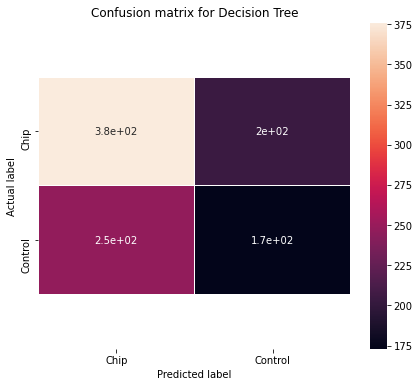

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score
from logitplots import plt_confusion_matrix
Y_pred = clf.predict(X_test) # calculate the predictions of the model for our test set
# plot the confusion matrix for the test and predicted target values
cm = confusion_matrix(y_test, Y_pred)
plt_confusion_matrix(cm, ['Chip','Control'], 'Decision Tree') 
print("Random Forest Accuracy:",np.round(accuracy_score(y_test, Y_pred),3)) # calculate and print the accuracy score

### Decision Tree

In [64]:
X = df_new.drop('chipOrControl', axis = 1)
y = df_new['chipOrControl']
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size =.5, random_state = 0)
clf = DecisionTreeClassifier(random_state = 0, min_samples_leaf=4).fit(X_train, y_train)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clf = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)

Decision Tree Accuracy: 0.594


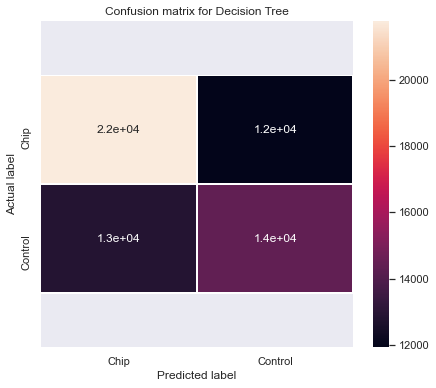

In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
from logitplots import plt_confusion_matrix
Y_pred = clf.predict(X_test) # calculate the predictions of the model for our test set
# plot the confusion matrix for the test and predicted target values
cm = confusion_matrix(y_test, Y_pred)
plt_confusion_matrix(cm, ['Chip','Control'], 'Decision Tree') 
print("Decision Tree Accuracy:",np.round(accuracy_score(y_test, Y_pred),3)) # calculate and print the accuracy score

Accuracy 0.5
Decision Tree Accuracy: 0.52


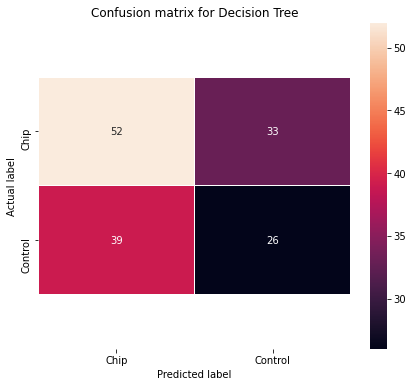

In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
decision_tree = DecisionTreeClassifier()
param_grid = {'criterion': ['gini','entropy'], 'min_samples_split': [2, 5, 10, 20, 50], 'max_leaf_nodes': [3,4,5,6,7,8,9], 'max_depth': [3, 4, 5, 6], 'random_state': [0]}

decision_tree_CV = GridSearchCV(estimator=decision_tree, param_grid=param_grid)
decision_tree_CV.fit(X_train, y_train)

y_pred = decision_tree_CV.predict(X_test)
cm = confusion_matrix(y_test, Y_pred)
plt_confusion_matrix(cm, ['Chip','Control'], 'Decision Tree') 
print("Decision Tree Accuracy:",np.round(accuracy_score(y_test, Y_pred),3)) # calculate and print the accuracy score

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

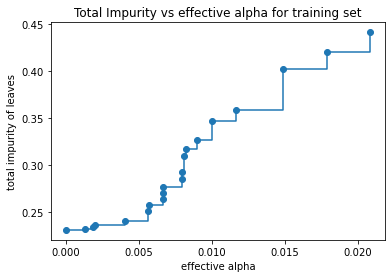

In [27]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [28]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 5 with ccp_alpha: 0.027069309685272103


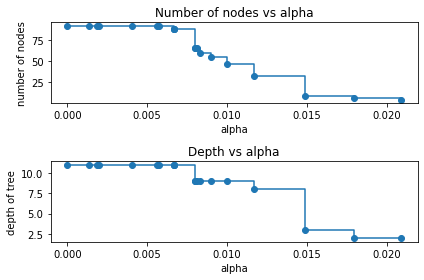

In [29]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

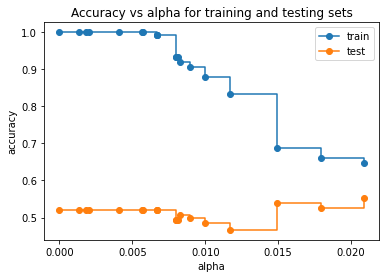

In [30]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

## Ada Boosting Classifier

In [12]:
from sklearn.ensemble import AdaBoostClassifier

In [13]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=0.5, algorithm= 'SAMME')
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)  # calculate the predicted values
# print the accuracy of the classifier
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_pred),3)))

Accuracy 0.609


In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=0.5, algorithm= 'SAMME')
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)  # calculate the predicted values
# print the accuracy of the classifier
print('Accuracy {0}'.format(np.round(accuracy_score(y_test, y_pred),3)))

In [14]:
FI = pd.Series(ada_clf.feature_importances_, index=X.columns)
FI.sort_values(ascending=False)

REFBIAS         0.315386
ODDRATIO        0.300622
AF              0.189961
QUAL            0.087007
VARBIAS         0.034219
sampleTimePt    0.020029
gender          0.019547
IMPACT          0.017066
other           0.006104
DNMT3A          0.003661
ASXL1           0.002910
TET2            0.002302
BCOR            0.001079
TP53            0.000107
dtype: float64

In [69]:
lrates = np.arange(0.2, 2.3, 0.3)
nests = np.arange(5, 105, 5)
results = np.zeros((len(nests), len(lrates)))
for i in range(len(lrates)):
    for j in range(len(nests)):
        print(i, j, end='\r')
        ada_clf = AdaBoostClassifier(n_estimators=nests[j], learning_rate=lrates[i])
        ada_clf.fit(X_train, y_train)
        y_pred = ada_clf.predict(X_test)  # calculate the predicted values
        # evaluate the model and collect the results
        results[j,i] = accuracy_score(y_test, y_pred)

results_df = pd.DataFrame(results, columns=np.round(lrates, 1), index=nests)
results_df

,0.2,0.5,0.8,1.1,1.4,1.7,2.0
5,0.552733,0.552733,0.552897,0.553946,0.555029,0.553471,0.552733
10,0.552733,0.552733,0.554078,0.553044,0.553208,0.553356,0.454698
15,0.552733,0.553356,0.553602,0.553077,0.553143,0.553405,0.552733
20,0.552733,0.553536,0.553881,0.554389,0.553372,0.553733,0.454698
25,0.552782,0.553700,0.553372,0.554078,0.554455,0.553487,0.552733
30,0.552782,0.552880,0.553487,0.553914,0.553356,0.554160,0.454698
35,0.552782,0.552634,0.553225,0.554045,0.553274,0.551519,0.552733
40,0.552864,0.553028,0.553946,0.554012,0.552831,0.551224,0.454698
45,0.553241,0.553143,0.553339,0.554028,0.552733,0.551355,0.552733
50,0.553208,0.553520,0.553520,0.554537,0.553159,0.550075,0.454698


In [72]:
results_df.agg(['idxmax', 'max','min'], axis=0)

,0.2,0.5,0.8,1.1,1.4,1.7,2.0
idxmax,95.000000,75.000000,95.000000,60.000000,5.000000,70.000000,5.000000
max,0.553963,0.554537,0.554602,0.556472,0.555029,0.554930,0.552733
min,0.552733,0.552634,0.552897,0.553044,0.552733,0.550075,0.454698


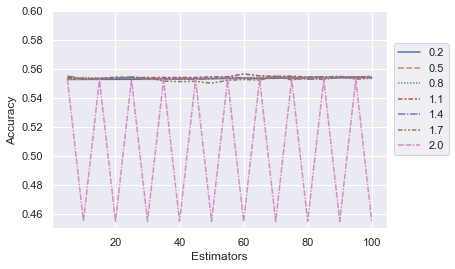

In [74]:
import seaborn as sns
sns.set();
sns.lineplot(data=results_df)
plt.ylim((.45,.6))
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.02, 0.85), loc='upper left', borderaxespad=0)

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

(0.45, 0.6)

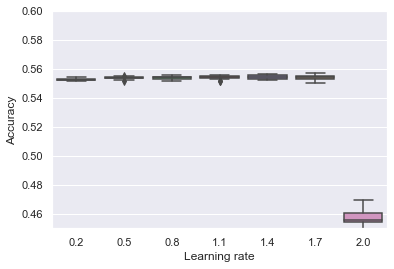

In [76]:
results = np.zeros((len(lrates),15))
for i in range(len(lrates)):
    model = AdaBoostClassifier(learning_rate=lrates[i])
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    results[i,:] = scores
    print('%.2f %.3f %.3f' % (i, np.mean(scores), np.std(scores)), end='\r')

results_df = pd.DataFrame(results.T, columns=np.round(lrates, 1))
sns.boxplot(data=results_df)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.ylim((.45,.6))

(0.5, 0.6)

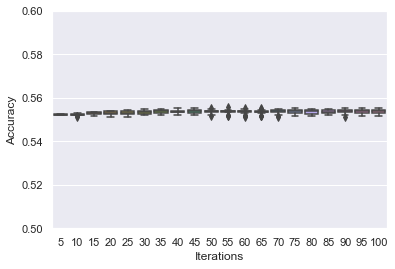

In [77]:
results = np.zeros((len(nests),15))
for i in np.arange(len(nests)):
    model = AdaBoostClassifier(n_estimators=nests[i], learning_rate=0.5)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
    results[i,:] = scores
    print('%.2f %.3f %.3f' % (i, np.mean(scores), np.std(scores)), end='\r')

results_df = pd.DataFrame(results.T, columns=nests)
sns.boxplot(data=results_df)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim((.54,.56))

Ada Boosted Accuracy: 0.556


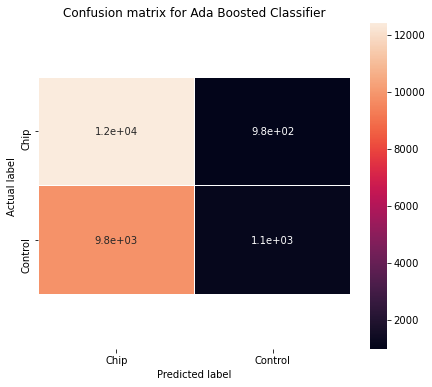

In [28]:
Y_pred = clf.predict(X_test3) # calculate the predictions of the model for our test set
# plot the confusion matrix for the test and predicted target values
cm = confusion_matrix(y_test3, Y_pred)
plt_confusion_matrix(cm, ['Chip','Control'], 'Ada Boosted Classifier') 
print("Ada Boosted Accuracy:",np.round(accuracy_score(y_test3, Y_pred),3)) # calculate and print the accuracy score

## Using DataFrame 2

In [ ]:
for i in df2:
    df2.dropna(subset=[i], how='any',inplace=True)
df2 = df2[(df2.chipOrControl != "Blank") & (df2.chipOrControl != "Unknown")]

refbias = []
for ratio in df2.REFBIAS.array:
    refbias.append(ratio_to_int(ratio)) 
df2['REFBIAS'] = pd.Series(refbias).values

location = []
for loci in df2.loci:
    location.append(loci.split(":")[0])

df2['loci_shortened'] = pd.Series(location, index=df2.index)
dict = {}
df2_new = df2
for ix, loci_shortened in zip(range(len(df2_new['loci_shortened'].unique())), df2_new['loci_shortened'].unique() ):
    dict[loci_shortened] = ix
    
df2 = df2.replace({'loci_shortened': dict})
df2["loci_shortened"] = df2["loci_shortened"].astype(str).astype(float)

df2 = df2.drop(['d.barcode','MSID','DP','HIAF','VD','loci','BIAS','VARBIAS'], axis = 1)
shorted = ['SYMBOL', 'IMPACT','sampleTimePt', 'gender', 'chipOrControl']
for i in shorted:
    df2[f"{i}"] = df2[f"{i}"].astype('category').cat.codes


In [25]:
X = shuffle(df2)
df2_new = X.head(20000)
df2_new['chipOrControl'].describe()
df2_new.head(10)##

,d.barcode,DP,VD,AF,HIAF,IMPACT,SYMBOL,loci,sampleTimePt,gender,MSID,BIAS,REFBIAS,VARBIAS,QUAL,ODDRATIO,chipOrControl
447850,4010289733,2432,6,0.0025,0.0033,MODERATE,DNMT3A,chr2:25471042_TCCA/GCCC,Baseline,Male,MS13311,2:0,823:1256,6:0,34.0,0.000000,Control
474357,4010289743,754,2,0.0027,0.0027,HIGH,DNMT3A,chr2:25463170_C/T,Baseline,Female,MS13994,2:2,388:362,1:1,37.0,1.071690,Control
664032,4010289806,1100,4,0.0036,0.0029,MODERATE,TET2,chr4:106157353_A/G,Y3,Male,MS11186,2:2,564:505,2:2,30.5,1.116720,Control
1133079,4010289939,4602,15,0.0033,0.0031,MODERATE,DNMT3A,chr2:25463239_A/G,Baseline,Male,MS9016,2:2,2332:2115,9:6,33.5,1.360322,Unknown
1213827,4010289962,8836,80,0.0091,0.0058,MODERATE,TET2,chr4:106155366_G/T,Y3,Male,MS13208,2:2,3214:5534,49:31,25.4,2.721311,Unknown
583669,4010289779,6407,36,0.0056,0.0049,MODERATE,TP53,chr17:7577096_T/C,Baseline,Female,MS4019,2:2,3149:3216,19:17,32.7,1.141396,CHIP
1077132,4010289920,2784,15,0.0054,0.0047,MODERATE,TET2,chr4:106194049_A/C,Blank,Blank,NaN,2:2,1439:1316,7:8,26.2,1.249570,NaN
693810,4010289818,394,2,0.0051,0.0052,MODERATE,TET2,chr4:106196280_C/G,Blank,Blank,NaN,2:2,200:191,1:1,37.0,1.047010,Blank
390816,4010289717,19490,49,0.0025,0.0021,MODERATE,RAD21,chr8:117875480_T/C,Baseline,Male,MS9816,2:2,9846:9578,21:28,31.0,1.370610,Control
1204515,4010289959,2163,32,0.0148,0.0288,MODERATE,ASXL1,chr20:31021164_T/G,Baseline,Male,MS9607,1:1,2125:0,32:0,30.8,0.000000,Unknown


## SVM


In [26]:
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsOneClassifier
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC

In [43]:
X = df_new.drop('chipOrControl', axis = 1)
XX = (X-X.mean())/X.std();
y = df_new['chipOrControl']
X_train, X_test, y_train, y_test = train_test_split(XX, y,train_size =.8, random_state = 10)

In [44]:
model = SVC(kernel='rbf', gamma='scale', C=1.E10,verbose=True) 
model.fit(X_train, y_train);

ovo = OneVsOneClassifier(model)
ovo.fit(X_train, y_train)
y_pred = ovo.predict(X_test)
print("Accuracy: ",np.round(accuracy_score(y_test, y_pred),3))

[LibSVM][LibSVM]Accuracy:  0.55


In [153]:
lst = []
lst2 = []
for i in decision_tree_CV.best_params_:
    lst.append("'" + str(decision_tree_CV.best_params_[i])+ "'")
    lst2.append(i)

i = 0
lst3 = []
while i < (len(lst)):
    best_params = str(lst2[i]) + ' = ' + str(lst[i])
    lst3.append(best_params)
    i += 1

converted = ','.join(lst3)
    
print(converted)

criterion = 'entropy',max_depth = '5',max_leaf_nodes = '6',min_samples_split = '20',random_state = '0'
